In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model
from os import makedirs
from sklearn.model_selection import KFold

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# split a multivariate sequence into samples for providing test samples
def split_sequences_test(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(int(len(sequences)/n_steps_out)):
        # find the end of this pattern
        end_ix = i*n_steps_out + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i*n_steps_out:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def MHMLP_model():
    n_input = 14
    n_features = 43
    n_out = 7
    visible = [Input(shape=(n_input,)) for i in range(n_features)]
    dense = [Dense(40, activation='relu')(visible[i]) for i in range(n_features)]
    merge = concatenate([dense[i] for i in range(n_features)])
    output = Dense(n_out)(merge)
    model = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
    model.compile(optimizer='Adam', loss='mse', metrics='mape')
    return model
model_MHMLP = MHMLP_model()

'''# turn MHMLP into pipeline with separate input data
estimators = []
estimators.append(( 'separator' , FeatureSeparator()))
estimators.append(( 'mlp' , model_MHMLP))
model_MHMLPpl = Pipeline(estimators)'''

def MHCNN_model():
    n_input = 14
    n_features = 43
    n_out = 7
    visible= [Input(shape=(n_input,1)) for i in range(n_features)]
    cnn = [Conv1D(filters=64, kernel_size=2, activation='relu')(visible[i]) for i in range(n_features)]
    cnn = [MaxPooling1D(pool_size=2)(cnn[i]) for i in range(n_features)]
    cnn = [Flatten()(cnn[i]) for i in range(n_features)]

    # merge input models
    merge = concatenate([cnn[i] for i in range(n_features)])
    dense = Dense(500, activation='relu')(merge)
    output = Dense(n_out)(dense)
    model = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model
model_MHCNN = MHCNN_model()




# get a list of models to evaluate
def get_models():
    models = dict()
    models['MHMLP'] = model_MHMLP
    models['MHCNN'] = model_MHCNN
    
    return models


# evaluate models using kfold validation
def get_kfvalid(model_list, n_slit, X_train, Y_train):
    seed = 7
    np.random.seed(seed)
    kf = KFold(n_splits=n_slit, shuffle=True, random_state=seed)    
    Scores = dict()
    Yhat = dict()
    Y = dict()
    for name, model in model_list.items():
        i=0
        cvscores = []
        cvyhat = []
        cvy = []
        if name == 'MHMLP':
            batch_size=30 
            epochs=2000
            for train, test in kf.split(X_train, Y_train):
                Xtr = [X_train[train][:, :, i] for i in range(43)]
                # Fit the model
                model.fit(Xtr , Y_train[train], epochs=epochs, verbose=0)
                # save model
                filename = 'weekbasemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                Xte = [X_train[test][:, :, i] for i in range(43)]
                scores = model.evaluate(Xte, train_y[test], verbose=0)
                cvscores.append(scores)
                # produce yhat
                y_hat = model.predict(Xte)
                y_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy
        
        if name == 'MHCNN':
            batch_size=30 
            epochs=3000
            for train, test in kf.split(X_train, Y_train):
                Xtr = [X_train[train][:, :, i] for i in range(43)]
                # Fit the model
                model.fit(Xtr , Y_train[train], epochs=epochs, verbose=0)
                # save model
                filename = 'weekbasemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                Xte = [X_train[test][:, :, i] for i in range(43)]
                scores = model.evaluate(Xte, train_y[test], verbose=0)
                cvscores.append(scores)
                # produce yhat
                y_hat = model.predict(Xte)
                y_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy    
    return Scores, Yhat, Y

# load models from file
def load_all_models(model_list, n_repeat):
    all_models = dict()
    for name in model_list:
        for i in range(n_repeat):
            # define filename for this ensemble
            filename =  name + '_' + str(i + 1) + '.h5'
            filedir = 'weekbasemodels/' + name + '_' + str(i + 1) + '.h5'
            # load model from file
            all_models[filename] = load_model(filedir)
            print('>loaded %s' % filename)
    return all_models


# evaluate models 
def evaluate_model(model, X, y):
    y_hat = model.predict(X)
    y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                                                              .reshape(-1, 1),np.zeros((y_hat.shape[0]*y_hat.shape[1],42))), axis=1))[:,0])-1
    yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((y.shape[0]*y.shape[1],42))), axis=1))[:,0])-1
    rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
    mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev)) 
    return rmse , mape, y_hat


# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX, y):
    stackX = None
    stack_mape = None
    stack_rmse = None
    for name, model in members.items():
        model.compile(optimizer='adam', loss='mse', metrics='mape')
        X = [inputX[:, :, i] for i in range(43)]
        rmse , mape, y_hat = evaluate_model(model, X, y)
        
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = y_hat
            stack_mape = mape
            stack_rmse = rmse
        else:
            stackX = np.dstack((stackX, y_hat))
            stack_mape = np.dstack((stack_mape, mape))
            stack_rmse = np.dstack((stack_rmse, rmse))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX, stack_mape, stack_rmse


# define stacked model from multiple member input models
def define_stacked_mlp():
    # update all layers in all models to not be trainable
    model = Sequential()
    model.add(Dense(320, activation='relu', input_dim=140))
    model.add(Dense(7))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model


# fit a stacked model
def fit_stacked_mlp(model, stackX, inputy):
    model.fit(stackX, inputy, epochs=2000, verbose=0)
    return model

# make a prediction with a stacked model
def predict_stacked_mlp(model, stackX):
    return model.predict(stackX, verbose=0)

# fit a model based on the outputs from the ensemble members
def fit_stacked_lr(stackedX, inputy):
    # fit standalone model
    model = LinearRegression()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def predict_stacked_lr(lrmodel, stackedX):
    # make a prediction
    yhat = lrmodel.predict(stackedX)
    return yhat

#***********************************************
#-------------------------
# Load Data
#-------------------------
    
df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 7

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y = split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y = split_sequences_test(sequences_test, n_input, n_out)

n_features = train_x.shape[2]
#--------------------------
# Define models using kersa and kerasregressor
#--------------------------

#n_repeat = 10
#makedirs('weekbasemodels')
#Base_models = get_models()
#Scores, Yhat, Y = get_kfvalid(Base_models, n_repeat, train_x, train_y)

# Load different fitted saved models
#Base_models_trained = load_all_models(list(Base_models.keys()), n_repeat)

# evaluate the basemodels and creat stack data base
#stackX0, mape0, rmse0 = stacked_dataset(Base_models_trained, train_x, train_y)

# build the stacked models using database0
stacked_mlp = define_stacked_mlp()
stacked_mlp = fit_stacked_mlp(stacked_mlp, stackX0, train_y)
stacked_lr = fit_stacked_lr(stackX0, train_y)

# make prediction based on training dataset
stackX1, mape1, rmse1 = stacked_dataset(Base_models_trained, test_x, test_y)
predict_smlp = predict_stacked_mlp(stacked_mlp, stackX1)
predict_slr = predict_stacked_lr(stacked_lr, stackX1 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp.reshape(predict_smlp.shape[0]*predict_smlp.shape[1])
                                                              .reshape(-1, 1),np.zeros((predict_smlp.shape[0]*predict_smlp.shape[1],42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr.reshape(predict_slr.shape[0]*predict_slr.shape[1])
                                                              .reshape(-1, 1),np.zeros((predict_slr.shape[0]*predict_slr.shape[1],42))), axis=1))[:,0])-1

yrev = np.exp(scaler.inverse_transform(np.concatenate((test_y.reshape(test_y.shape[0]*test_y.shape[1])
                                                              .reshape(-1, 1),np.zeros((test_y.shape[0]*test_y.shape[1],42))), axis=1))[:,0])-1
rmse_smlp = np.sqrt(np.mean((yrev-y_hatrev_smlp)**2))
mape_smlp = np.mean(np.abs((yrev-y_hatrev_smlp)*100/yrev)) 

rmse_slr = np.sqrt(np.mean((yrev-y_hatrev_slr)**2))
mape_slr = np.mean(np.abs((yrev-y_hatrev_slr)*100/yrev))


In [32]:
np.save('stackX0.npy', stackX0, allow_pickle=True)
np.save('stackX1.npy', stackX1, allow_pickle=True)
np.save('rmse0.npy', rmse0, allow_pickle=True)
np.save('rmse1.npy', rmse1, allow_pickle=True)
np.save('mape0.npy', mape0, allow_pickle=True)
np.save('mape1.npy', mape1, allow_pickle=True)
np.save('Y.npy', Y, allow_pickle=True)
np.save('Yhat.npy', Yhat, allow_pickle=True)
np.save('Scores.npy', Scores, allow_pickle=True)

In [43]:
Scores_rev=dict()
for name in list(Base_models.keys()):
    score=[]
    for i in range(10):
        y_hat = Yhat[name][i]
        y = Y[name][i]
        y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(-1, 1),np.zeros((len(y_hat),42))), axis=1))[:,0])-1
        yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((y.shape[0]*y.shape[1],42))), axis=1))[:,0])-1
        rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
        mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev))
        score.append([rmse, mape])
        Scores_rev[name]=score

In [44]:
Scores_rev

{'MHMLP': [[36.430354852124964, 7.305974941653139],
  [25.358646155986293, 4.619106416468832],
  [17.570526235501944, 3.683154571068265],
  [12.923154651440745, 3.2944423232923503],
  [14.64417925213957, 3.2776904510763436],
  [18.016139135922327, 2.89555619828126],
  [16.490287307739315, 2.7446715377113535],
  [14.90343376115552, 2.933937989960356],
  [13.226353388075752, 2.5559558208863264],
  [14.500720555055613, 2.4211447401672985]],
 'MHCNN': [[30.170747097767702, 5.754918107023355],
  [16.80473938885275, 2.952273332300922],
  [10.977126387647006, 2.190703696283793],
  [8.014337226393478, 1.8101318772605846],
  [7.566463746676458, 1.5556817460992756],
  [10.958404140685385, 1.4267715167146326],
  [6.837832976638824, 1.3201753737876243],
  [5.66761145172386, 1.2106766812966785],
  [5.7512343890552735, 1.1597584885036214],
  [5.864489356775545, 1.3069879029560776]]}

<Figure size 1200x600 with 0 Axes>

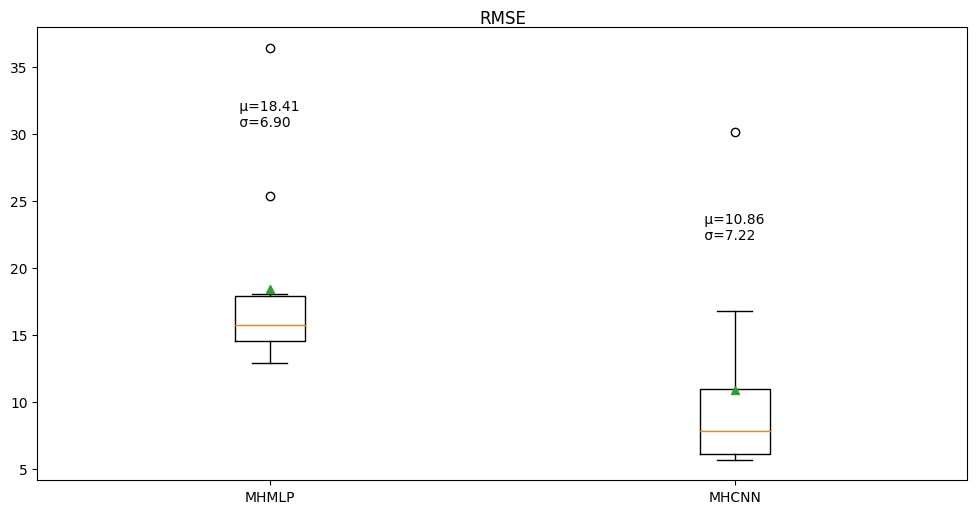

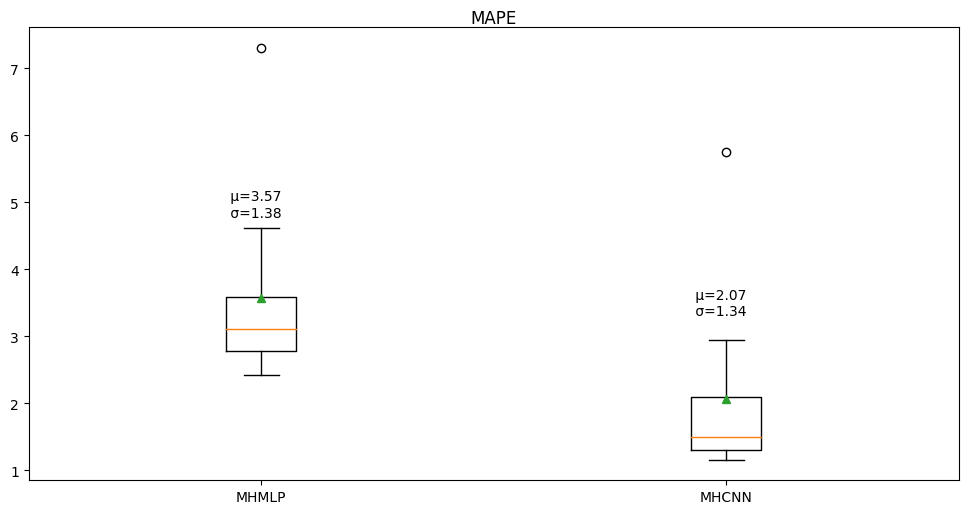

In [47]:
name=['MHMLP','MHCNN'] 
rmse=[]
mape=[]
for i in range(2):
    a=[Scores_rev[name[i]][k][0] for k in range(10)]
    b=[Scores_rev[name[i]][k][1] for k in range(10)]
    rmse.append(a)  
    mape.append(b)
plt.figure(figsize=(12,6), dpi=100)
fig1, ax1 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('RMSE', pad=-40)
bp1 = plt.boxplot(rmse, labels=name, showmeans=True)
m1 = np.mean(rmse,1)
st1 = np.std(rmse,1)

for i, line in enumerate(bp1['boxes']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    ax1.annotate(text, xy=(x, y+16))

    
fig2, ax2 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('MAPE', pad=-40)
bp2 = plt.boxplot(mape, labels=name, showmeans=True)
m2 = np.mean(mape,1)
st2 = np.std(mape,1)

for i, line in enumerate(bp2['boxes']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    ax2.annotate(text, xy=(x, y+2))
    
plt.show()

<Figure size 1200x600 with 0 Axes>

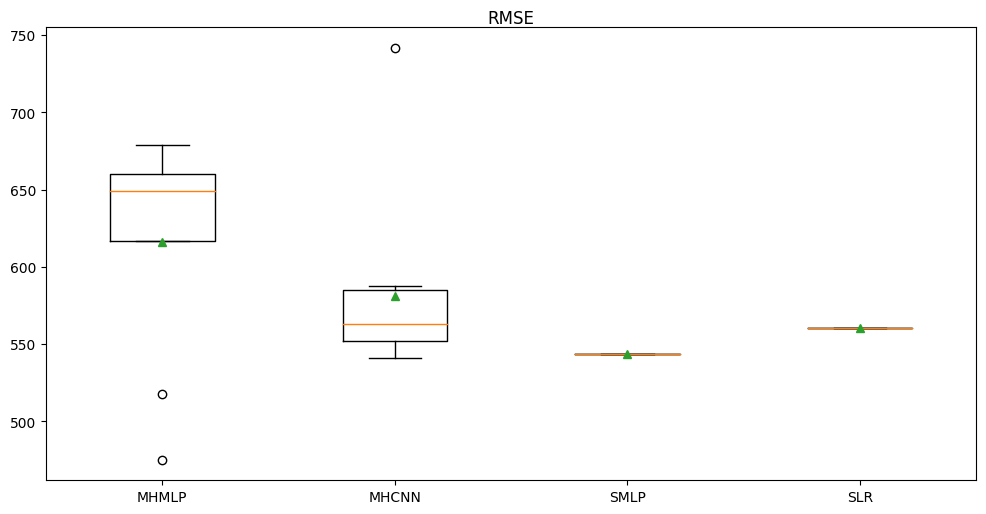

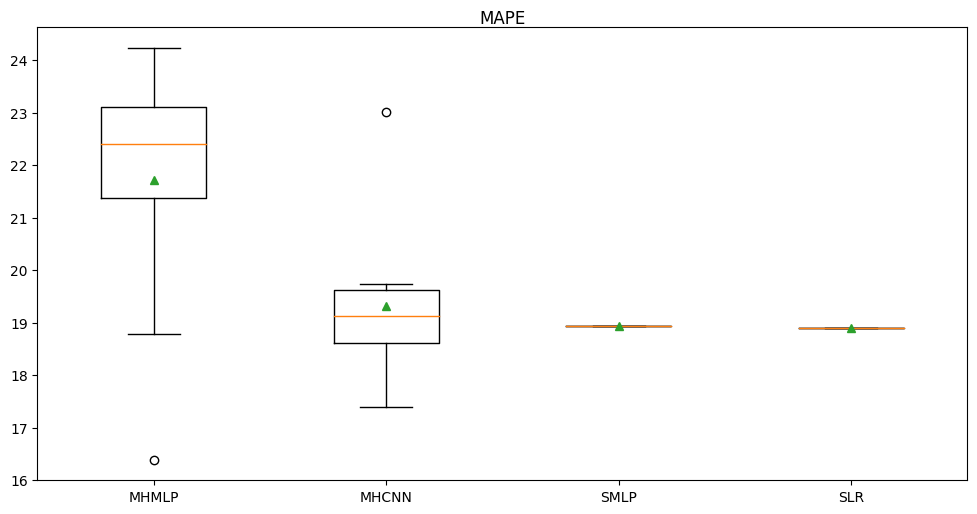

In [48]:
name=['MHMLP','MHCNN','SMLP', 'SLR'] 
rmse=[]
mape=[]
for i in range(2):
    rmse.append(rmse1[0,0,i*10:(i+1)*10-1])  
    mape.append(mape1[0,0,i*10:(i+1)*10-1])
rmse.append(array([rmse_smlp]))
rmse.append(array([rmse_slr]))
mape.append(array([mape_smlp]))
mape.append(array([mape_slr]))

plt.figure(figsize=(12,6), dpi=100)
fig1, ax1 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('RMSE', pad=-40)
bp1 = plt.boxplot(rmse, labels=name, showmeans=True)
m1 = [rmse[i].mean() for i in range(4)]
st1 = [rmse[i].std() for i in range(4)]

for i, line in enumerate(bp1['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    ax1.annotate(text, xy=(x-0.35, y+320))

    
fig2, ax2 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('MAPE', pad=-40)
bp2 = plt.boxplot(mape, labels=name, showmeans=True)
m2 = [mape[i].mean() for i in range(4)]
st2 = [mape[i].std() for i in range(4)]

for i, line in enumerate(bp2['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    ax2.annotate(text, xy=(x-0.35, y+12.4))
    
plt.show()

In [60]:
print(stackX1.shape)
print(stackX1)


(22, 140)
[[0.5552133  0.5456915  0.5461548  ... 0.5754457  0.5701628  0.5721831 ]
 [0.59095967 0.61006945 0.6152602  ... 0.5722445  0.57347095 0.56778544]
 [0.6642091  0.66524386 0.6792741  ... 0.6509188  0.65529966 0.6517512 ]
 ...
 [1.0113894  0.9855106  0.92915124 ... 0.8834966  0.8925912  0.87503785]
 [0.9577846  0.9421426  0.8984654  ... 0.90781224 0.9158282  0.8917761 ]
 [0.936502   0.86035687 0.86397237 ... 0.83889604 0.8389279  0.8134899 ]]


In [112]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from kalmanfilter import KalmanFilter


def roll_mean_filter(history,sequence):
    sudo = history + sequence
    rolling = pd.Series(sudo).rolling(window=7)
    rolling_mean = rolling.mean()
    filtpred = list(rolling_mean[-7:].values)
    return filtpred
        

def simex_filter(history,sequence):
    sudo = history + sequence
    model = SimpleExpSmoothing(np.asarray(sudo))
    fit = model.fit(smoothing_level=.18)
    fitvalue = fit.fittedvalues
    filtpred = list(fitvalue[-7:])
    return filtpred


def Kfilter(sequence):
    if __name__ == "__main__":
        # generate noisy observations
        Z = sequence

        # kalman settings
        A = np.expand_dims(np.ones((len(Z),1)), axis=1) # transition matrix
        xk = np.array([[1]]) # initial mean estimate

        B = np.expand_dims(np.zeros((len(Z),1)), axis=1) # control-input matrix
        U = np.zeros((len(Z), 1)) # control-input vector

        Pk = np.array([[1]]) # initial covariance estimate
        Q = np.ones((len(Z))) * 0.0003 # process noise covariance

        H = A.copy() # observation matrix
        R = np.ones((len(Z))) * 0.011 # measurement noise covariance

        # run Kalman filter
        kf = KalmanFilter(A=A, xk=xk, B=B, Pk=Pk, H=H, Q=Q, R=R)
        states, errors = kf.filter(Z=Z, U=U)
        kalman_gain = np.stack([val.item() for val in kf.kalman_gains])
        # as a flat array
        states = np.stack([val.item() for val in states])
    return states
def kalman_filter(history,sequence):
    sudo = history + sequence
    states = Kfilter(sudo)
    filtpred = list(states[-7:])
    return filtpred

def eval_prediction(y_hat, y):
    y_hat = array(y_hat)
    y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(-1, 1),np.zeros((len(y_hat),42))), axis=1))[:,0])-1
    yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((y.shape[0]*y.shape[1],42))), axis=1))[:,0])-1
    rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
    mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev)) 
    return rmse , mape
#---------------------------------------------

model_predictions = dict()
rolmean_predictions = dict()
simex_predictions = dict()
kfilter_predictions = dict()

model_errors = dict()
rolmean_errors = dict()
simex_errors = dict()
kfilter_errors = dict()

for i in range(len(Base_models_trained.keys())):
    history = list(y_train)
    name = list(Base_models_trained.keys())[i]
    prediction = []
    rollfilter = []
    simexfilter = []
    Kalmanfilter = []
    
    for j in range(len(stackX1)):
        pred = list(stackX1[j, i*7:(i+1)*7])
        prediction = prediction + pred
        rollfilter = rollfilter + roll_mean_filter(history,pred)
        simexfilter = simexfilter + simex_filter(history,pred)
        Kalmanfilter = Kalmanfilter + kalman_filter(history,pred)
        history = history + list(test_y[j])
   
    model_predictions[name] = prediction
    rolmean_predictions[name] = rollfilter
    simex_predictions[name] = simexfilter
    kfilter_predictions[name] = Kalmanfilter
    
     # calculate errors
    model_errors [name] = eval_prediction(prediction, test_y)
    rolmean_errors [name] = eval_prediction(rollfilter, test_y)
    simex_errors [name] = eval_prediction(simexfilter, test_y)
    kfilter_errors [name] = eval_prediction(Kalmanfilter, test_y)

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\98912\.virtualen

In [113]:
model_errors

{'MHMLP_1.h5': (472.80745659807405, 15.217505438314207),
 'MHMLP_2.h5': (518.3117359949609, 17.60476470482022),
 'MHMLP_3.h5': (448.1660314973016, 15.40861490193069),
 'MHMLP_4.h5': (521.80559748401, 18.743767973297768),
 'MHMLP_5.h5': (620.3449854091822, 23.35399700969231),
 'MHMLP_6.h5': (622.1504046419125, 23.43653664132269),
 'MHMLP_7.h5': (944.5747013936353, 35.827538210791694),
 'MHMLP_8.h5': (683.1679103136228, 21.839118610673545),
 'MHMLP_9.h5': (465.8960504634257, 16.728159696588357),
 'MHMLP_10.h5': (547.9553331125448, 20.82701321573192),
 'MHCNN_1.h5': (586.4497430280246, 22.676732028081148),
 'MHCNN_2.h5': (627.8567892485463, 23.00705964359974),
 'MHCNN_3.h5': (669.0688257958749, 23.134088412511964),
 'MHCNN_4.h5': (529.8510682361954, 17.404848015468556),
 'MHCNN_5.h5': (560.5602768970442, 18.48560690684141),
 'MHCNN_6.h5': (602.664311091447, 19.361898254461746),
 'MHCNN_7.h5': (573.966352641708, 18.545332218385663),
 'MHCNN_8.h5': (563.2934725796327, 19.501621575774283),
 

In [114]:
rolmean_errors

{'MHMLP_1.h5': (351.3255895206973, 12.21912090586243),
 'MHMLP_2.h5': (368.73033667558286, 13.488726533269377),
 'MHMLP_3.h5': (422.33434646412445, 14.085101656517486),
 'MHMLP_4.h5': (378.94107641042046, 13.63935057365441),
 'MHMLP_5.h5': (458.7784508854682, 16.84482003630263),
 'MHMLP_6.h5': (502.2522302480205, 17.846258167810056),
 'MHMLP_7.h5': (696.231456021444, 25.188808661345423),
 'MHMLP_8.h5': (447.32160855381426, 14.923163403299347),
 'MHMLP_9.h5': (402.97508926844233, 13.746415451219503),
 'MHMLP_10.h5': (431.22221702594874, 15.98696772715785),
 'MHCNN_1.h5': (484.31939475399423, 17.324795683459676),
 'MHCNN_2.h5': (482.1040440790158, 16.59629059674662),
 'MHCNN_3.h5': (508.99782178492495, 17.53202389062515),
 'MHCNN_4.h5': (447.52369955220377, 14.470825878037788),
 'MHCNN_5.h5': (414.773169181731, 13.634641679341104),
 'MHCNN_6.h5': (448.07628167769985, 14.566450208494643),
 'MHCNN_7.h5': (468.0404954805737, 15.126807194609171),
 'MHCNN_8.h5': (430.4959206566677, 14.3837489

In [115]:
simex_errors

{'MHMLP_1.h5': (371.4921233512403, 12.837249516914532),
 'MHMLP_2.h5': (387.55955270034343, 13.881599253742266),
 'MHMLP_3.h5': (429.92022069869074, 14.505775702388942),
 'MHMLP_4.h5': (375.44125354631547, 13.525971729944269),
 'MHMLP_5.h5': (446.0774286202727, 16.29700096471887),
 'MHMLP_6.h5': (479.03748826753116, 16.818609588283895),
 'MHMLP_7.h5': (606.111541068356, 21.577792215134),
 'MHMLP_8.h5': (457.6848714933369, 15.42697284543069),
 'MHMLP_9.h5': (413.543114372898, 14.178939878743654),
 'MHMLP_10.h5': (420.00766601502, 15.440020686369888),
 'MHCNN_1.h5': (471.689624991558, 16.79065835655759),
 'MHCNN_2.h5': (461.64710505639425, 16.103332702149263),
 'MHCNN_3.h5': (484.31839611165606, 16.711612698742513),
 'MHCNN_4.h5': (445.71700123662845, 14.827576969066927),
 'MHCNN_5.h5': (420.87229980832956, 14.239456391934626),
 'MHCNN_6.h5': (448.1500770798953, 14.912027772120512),
 'MHCNN_7.h5': (456.62242704818385, 15.189591274337754),
 'MHCNN_8.h5': (426.2343298468807, 14.49161896990

In [116]:
kfilter_errors

{'MHMLP_1.h5': (379.23455862728133, 13.203444851983367),
 'MHMLP_2.h5': (401.13287121610347, 14.392823803663225),
 'MHMLP_3.h5': (432.62178991062643, 14.91207639864286),
 'MHMLP_4.h5': (386.82222700579524, 14.06722796669717),
 'MHMLP_5.h5': (465.17036873417067, 17.105476992539167),
 'MHMLP_6.h5': (491.6362008286875, 17.53276717331695),
 'MHMLP_7.h5': (630.6860160285466, 23.015135514192398),
 'MHMLP_8.h5': (459.39579998288207, 15.755679502430278),
 'MHMLP_9.h5': (417.8997400844244, 14.730176372362237),
 'MHMLP_10.h5': (432.61425799969555, 15.997561619310558),
 'MHCNN_1.h5': (484.3230610574578, 17.52075511077469),
 'MHCNN_2.h5': (479.17606370824416, 16.80849780970816),
 'MHCNN_3.h5': (498.5083763009991, 17.394267513898935),
 'MHCNN_4.h5': (455.43596901044515, 15.39936455051467),
 'MHCNN_5.h5': (433.45429927303155, 14.524892263188924),
 'MHCNN_6.h5': (461.15400007706864, 15.481859423141403),
 'MHCNN_7.h5': (470.5787442291605, 15.70071353333409),
 'MHCNN_8.h5': (440.02191392317565, 14.9919

<Figure size 1200x600 with 0 Axes>

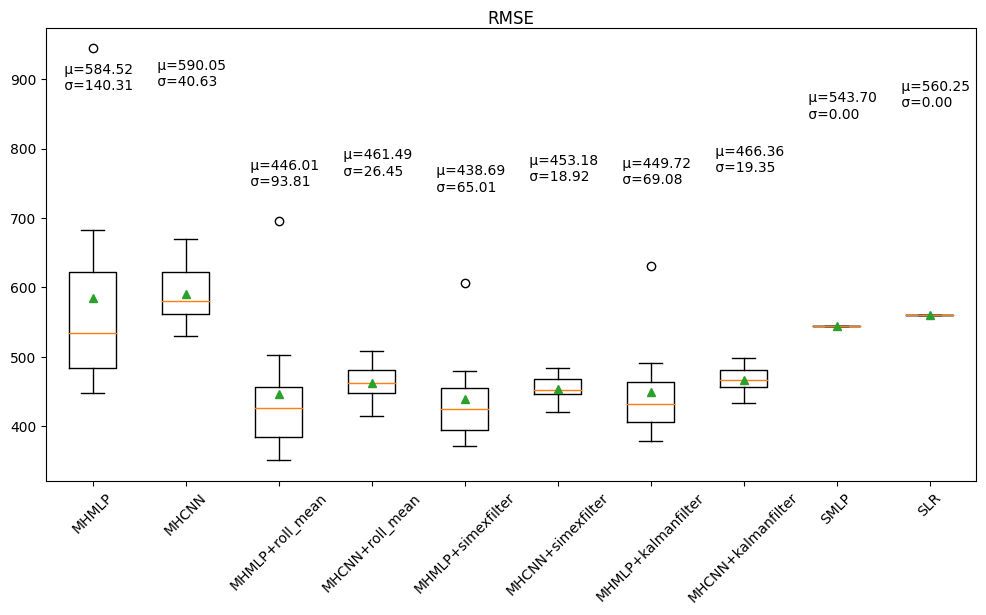

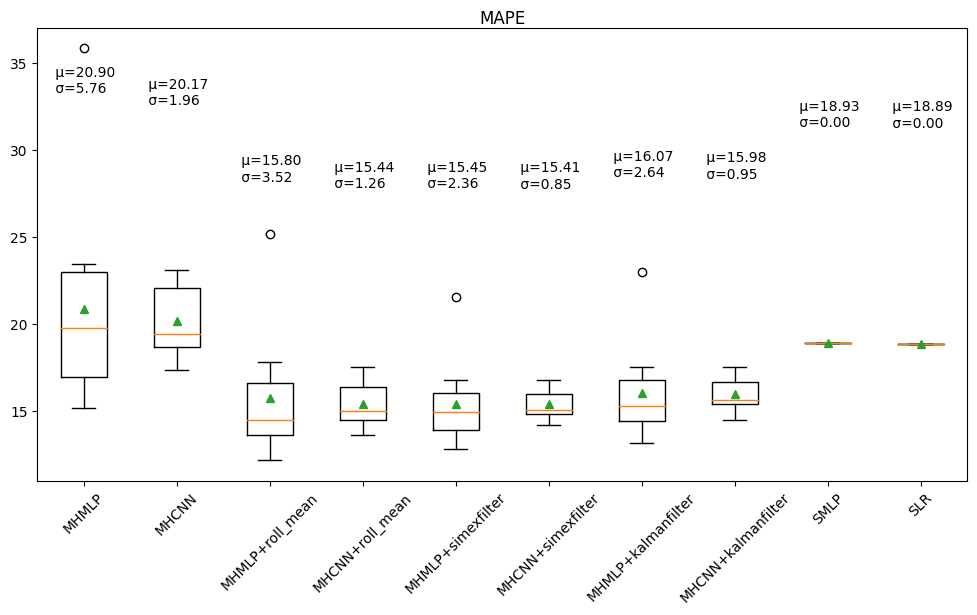

In [142]:
name=['MHMLP','MHCNN','MHMLP+roll_mean','MHCNN+roll_mean', 'MHMLP+simexfilter','MHCNN+simexfilter', 'MHMLP+kalmanfilter','MHCNN+kalmanfilter','SMLP', 'SLR'] 
rmse=[]
mape=[]

rmse.append([list(model_errors.values())[i][0] for i in range(0,10)])
rmse.append([list(model_errors.values())[i][0] for i in range(10,20)])
mape.append([list(model_errors.values())[i][1] for i in range(0,10)])
mape.append([list(model_errors.values())[i][1] for i in range(10,20)])

rmse.append([list(rolmean_errors.values())[i][0] for i in range(0,10)])
rmse.append([list(rolmean_errors.values())[i][0] for i in range(10,20)])
mape.append([list(rolmean_errors.values())[i][1] for i in range(0,10)])
mape.append([list(rolmean_errors.values())[i][1] for i in range(10,20)])

rmse.append([list(simex_errors.values())[i][0] for i in range(0,10)])
rmse.append([list(simex_errors.values())[i][0] for i in range(10,20)])
mape.append([list(simex_errors.values())[i][1] for i in range(0,10)])
mape.append([list(simex_errors.values())[i][1] for i in range(10,20)])

rmse.append([list(kfilter_errors.values())[i][0] for i in range(0,10)])
rmse.append([list(kfilter_errors.values())[i][0] for i in range(10,20)])
mape.append([list(kfilter_errors.values())[i][1] for i in range(0,10)])
mape.append([list(kfilter_errors.values())[i][1] for i in range(10,20)])

rmse.append(array([rmse_smlp]))
rmse.append(array([rmse_slr]))
mape.append(array([mape_smlp]))
mape.append(array([mape_slr]))

plt.figure(figsize=(12,6), dpi=100)
fig1, ax1 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('RMSE', pad=-40)
bp1 = plt.boxplot(rmse, labels=name, showmeans=True)
m1 = [np.mean(rmse[i]) for i in range(10)]
st1 = [np.std(rmse[i]) for i in range(10)]

for i, line in enumerate(bp1['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    ax1.annotate(text, xy=(x-0.35, y+300))
plt.xticks(rotation=45)
    
fig2, ax2 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('MAPE', pad=-40)
bp2 = plt.boxplot(mape, labels=name, showmeans=True)
m2 = [np.mean(mape[i]) for i in range(10)]
st2 = [np.std(mape[i]) for i in range(10)]

for i, line in enumerate(bp2['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    ax2.annotate(text, xy=(x-0.35, y+12.4))
plt.xticks(rotation=45)    
plt.show()

In [134]:
rmse

[[472.80745659807405,
  518.3117359949609,
  448.1660314973016,
  521.80559748401,
  620.3449854091822,
  622.1504046419125,
  944.5747013936353,
  683.1679103136228,
  465.8960504634257,
  547.9553331125448],
 [586.4497430280246,
  627.8567892485463,
  669.0688257958749,
  529.8510682361954,
  560.5602768970442,
  602.664311091447,
  573.966352641708,
  563.2934725796327,
  633.2300360237339,
  553.5745345128605],
 [351.3255895206973,
  368.73033667558286,
  422.33434646412445,
  378.94107641042046,
  458.7784508854682,
  502.2522302480205,
  696.231456021444,
  447.32160855381426,
  402.97508926844233,
  431.22221702594874],
 [484.31939475399423,
  482.1040440790158,
  508.99782178492495,
  447.52369955220377,
  414.773169181731,
  448.07628167769985,
  468.0404954805737,
  430.4959206566677,
  475.31687644577164,
  455.2690487893612],
 [371.4921233512403,
  387.55955270034343,
  429.92022069869074,
  375.44125354631547,
  446.0774286202727,
  479.03748826753116,
  606.111541068356,


In [138]:
[np.mean(rmse[i]) for i in range(10)]

[584.5180206908669,
 590.0515410055068,
 446.0112401073963,
 461.4916752401944,
 438.6875260134005,
 453.1838555666327,
 449.72138304182135,
 466.35597653296566,
 543.6987046801496,
 560.2488572148319]